# Bayesian Reinforcement Learning Model

Implementation of the final instance.



WCST encoding:

$$
1 =correct \\
2 = wrong \ card \\
3 =too \ slow
$$


-----
```
author:         Zach Wolpe
email:          zachcolinwolpe@gmail.com
reviewer:       n/a
date:           27 Dec 21
```
-----

In [1]:
import sys
sys.path.append('../process data')
from dependencies import *

In [9]:
# create location --------------------------*
store_loc = '../model-free analysis/final_dataframes'

# load -------------------------------------*
wcst_data   = pd.read_pickle(store_loc + '/wcst_raw_data.pkl')
covariates  = pd.read_pickle(store_loc + '/covariates.pkl')

In [10]:
wcst_data.head()

,participant,participant_code,card_no,correct_card,correct_persevering,seq_no,rule,card_shape,card_number,card_colour,reaction_time_ms,status,card_selected,error,perseverance_error,not_perseverance_error
0,816404.0,s.6463d918-7e29-49b0-942d-f1a9faab6ad6.txt,52,1,0,1,shape,triangle,1,yellow,3775,1,1,0,0,0
1,816404.0,s.6463d918-7e29-49b0-942d-f1a9faab6ad6.txt,59,3,0,2,shape,triangle,3,red,3771,1,3,0,0,0
2,816404.0,s.6463d918-7e29-49b0-942d-f1a9faab6ad6.txt,23,2,0,3,shape,cross,2,red,1359,1,2,0,0,0
3,816404.0,s.6463d918-7e29-49b0-942d-f1a9faab6ad6.txt,52,1,0,4,shape,triangle,1,yellow,1209,1,1,0,0,0
4,816404.0,s.6463d918-7e29-49b0-942d-f1a9faab6ad6.txt,52,1,0,5,shape,triangle,1,yellow,953,1,1,0,0,0


In [11]:
covariates.head()

,nback_status,nback_reaction_time_ms,fitts_mean_deviation,corsi_block_span,wcst_accuracy,wcst_RT,demographics_age_a,demographics_gender_a,demographics_handedness_a,demographics_education_a,demographics_income_a,demographics_computer_hours_a,demographics_age_group,demographics_mean_reation_time_ms,navon_perc_correct,navon_reaction_time_ms,global_local
participant,,,,,,,,,,,,,,,,,
100934.0,0.900,2225.9125,-5.70,4.0,0.84,1795.16,28.0,male,right,university,7.0,25.0,25-34,11453.571429,0.314103,631.176282,-0.294872
103322.0,0.925,2373.6250,-203.05,6.0,0.87,1406.27,51.0,male,right,university,6.0,82.0,45-54,5294.428571,0.919872,979.759615,0.006410
107700.0,0.950,2138.7750,-342.65,6.0,0.83,1415.35,35.0,male,right,university,4.0,4.0,25-34,4175.714286,0.919872,710.958333,-0.006410
117200.0,0.775,2403.7500,-85.05,4.0,0.79,1154.50,39.0,male,right,university,3.0,34.0,35-44,3637.142857,0.291667,691.000000,0.083333
117306.0,0.975,2343.2625,-141.80,5.0,0.83,2044.93,28.0,male,right,university,3.0,5.0,25-34,7471.142857,0.762821,1290.333333,-0.141026


In [139]:
# join dataframes

wcst_data.columns
wcst_data.iloc[0,:]

dataframe_core = wcst_data[['participant', 'reaction_time_ms', 'rule', 'card_shape', 'card_number', 'card_colour', 'status']].copy()
dataframe_core.set_index('participant')

,reaction_time_ms,rule,card_shape,card_number,card_colour,status
participant,,,,,,
816404.0,3775,shape,triangle,1,yellow,1
816404.0,3771,shape,triangle,3,red,1
816404.0,1359,shape,cross,2,red,1
816404.0,1209,shape,triangle,1,yellow,1
816404.0,953,shape,triangle,1,yellow,1
...,...,...,...,...,...,...
684712.0,1761,color,triangle,4,blue,1
684712.0,1109,color,circle,4,green,1
684712.0,1045,color,circle,4,green,1


In [136]:

# random sample 
p = np.random.choice(dataframe_core.participant)

df = dataframe_core.loc[dataframe_core.participant==p, :]



correct = df.status == 1
cum_correct = np.cumsum(correct)/(df.index+1)

cum_correct = cum_correct.reset_index(drop=True)
px.scatter(cum_correct, template='none', title='Participant: ' + str(p))

# Learning Model

In [140]:
# random sample 
p = np.random.choice(dataframe_core.participant)

df = dataframe_core.loc[dataframe_core.participant==p, :]
df = df.set_index('participant')

# Pyro Example

In [147]:
# !conda install -c conda-forge pyro-ppl -y

import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

import pyro
plt.style.use('default')


In [174]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

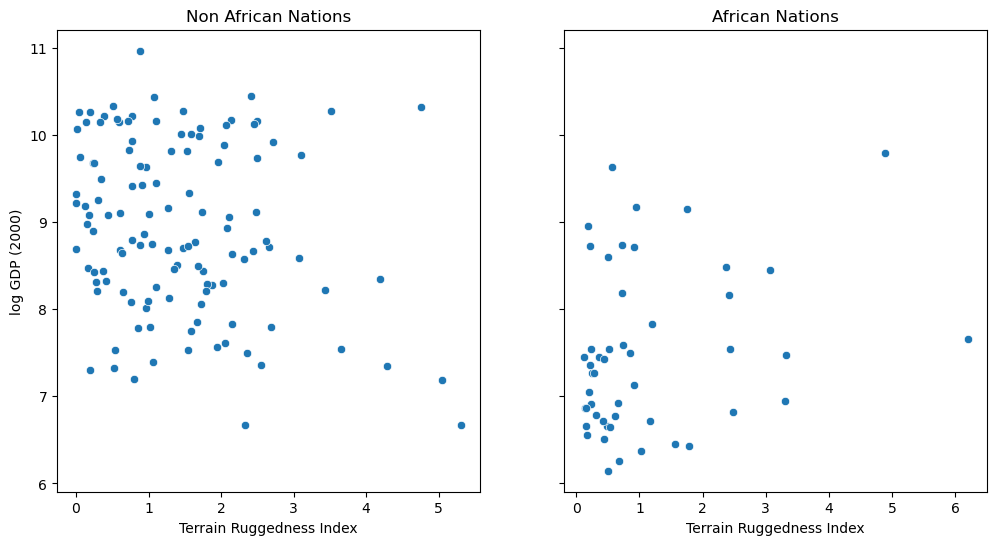

In [151]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

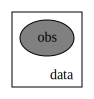

In [162]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp))

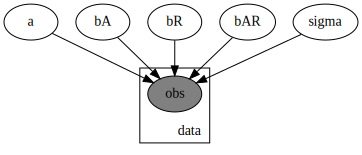

In [165]:


def model(is_cont_africa, ruggedness, log_gdp=None):
    a       = pyro.sample("a", dist.Normal(0., 10.))
    b_a     = pyro.sample("bA", dist.Normal(0., 1.))
    b_r     = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar    = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma   = pyro.sample("sigma", dist.Uniform(0., 10.))

    # model
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # parallelized loop through data
    with pyro.plate('data', len(ruggedness)):
        return pyro.sample('obs', dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp))


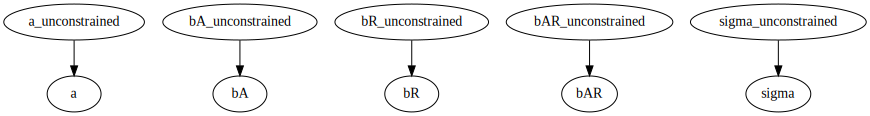

In [168]:

auto_guide = pyro.infer.autoguide.AutoNormal(model)
pyro.render_model(auto_guide, model_args=(is_cont_africa, ruggedness, log_gdp))

In [172]:
adam = pyro.optim.Adam({'lr': 0.02})
elbo = pyro.infer.Trace_ELBO()
svi  = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 694.9404826164246
Elbo loss: 524.3822077512741
Elbo loss: 475.668145775795
Elbo loss: 399.9908837676048
Elbo loss: 315.23277485370636
Elbo loss: 254.76769989728928
Elbo loss: 248.237040579319
Elbo loss: 248.4266900420189
Elbo loss: 248.46450024843216
Elbo loss: 257.4146338701248


CPU times: user 2.2 s, sys: 33 ms, total: 2.23 s
Wall time: 2.25 s


Text(0, 0.5, 'ELBO loss')

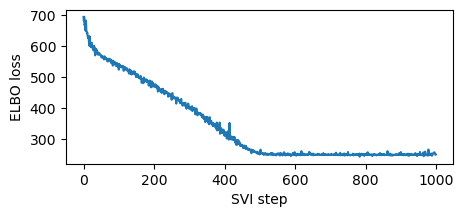

In [175]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))


plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [177]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.07036688
AutoNormal.locs.bA -1.847466
AutoNormal.scales.bA 0.14070092
AutoNormal.locs.bR -0.19032115
AutoNormal.scales.bR 0.044044234
AutoNormal.locs.bAR 0.35599765
AutoNormal.scales.bAR 0.079374395
AutoNormal.locs.sigma -2.2058632
AutoNormal.scales.sigma 0.06052672


In [178]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]


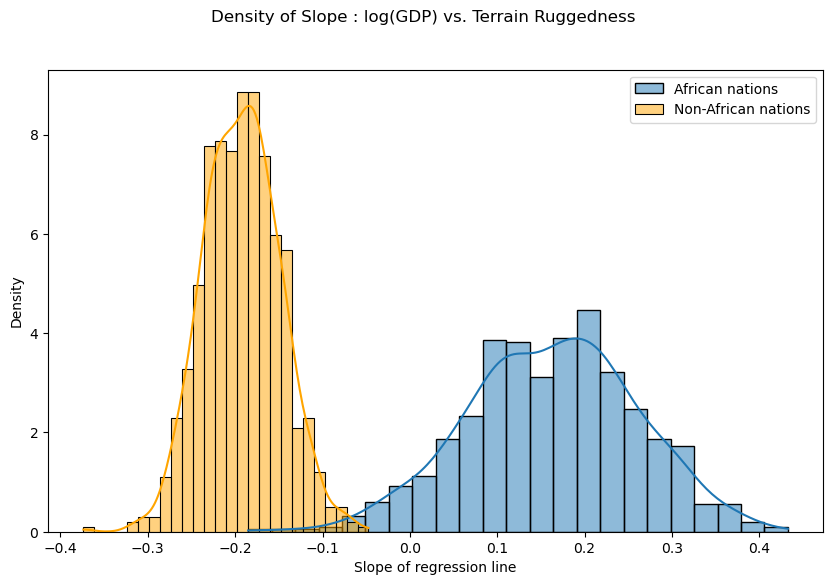

In [182]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [183]:
predictive  = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp     = svi_samples["obs"]

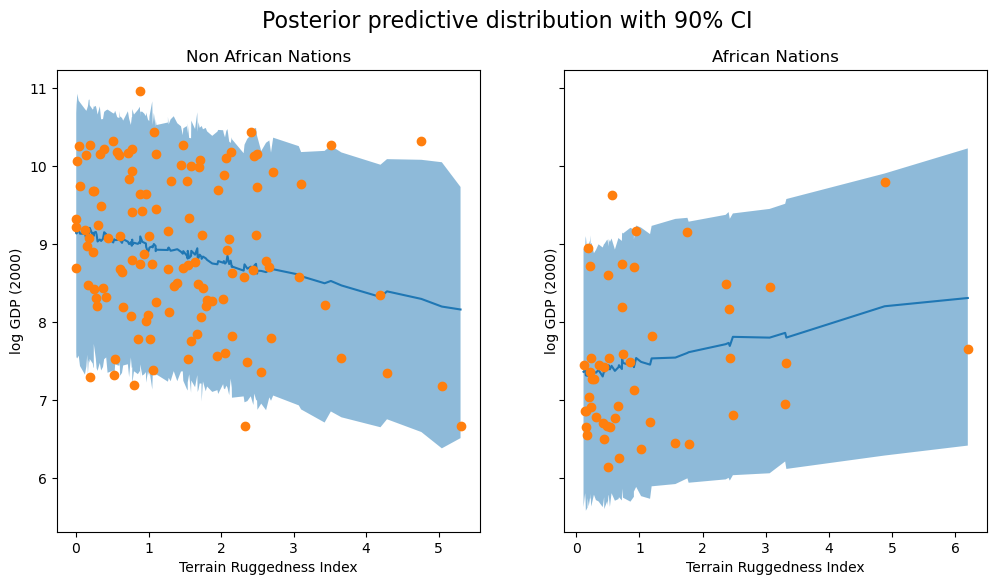

In [184]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

# PyMC3 RL Model

In [ ]:
import numpy as np
!pip install ArviZ==0.11.2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

In [4]:
sns.set(font_scale=1.5)
np.random.seed(632020)

In [5]:
def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(20,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)

    s = 50
    lw = 2

    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    plt.scatter(0, 20, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20, 20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    plt.yticks([0,1], ['left', 'right'])
    plt.ylim(-1, 2)

    plt.ylabel('action')
    plt.xlabel('trial')

    handles, labels = plt.gca().get_legend_handles_labels()
    order = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels = [labels[idx] for idx in order]

    plt.legend(handles, labels, fontsize=12, loc=(1.01, .27))
    plt.tight_layout()

## Generate fake data

In [6]:
def generate_data(alpha, beta, n=100, p_r=[.4, .6]):
    actions = np.zeros(n, dtype=np.int)
    rewards = np.zeros(n, dtype=np.int)
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([.5, .5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta*Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = np.random.choice([0, 1], p=prob_a)
        r = np.random.rand() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_32388/1049557006.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = np.zeros(n, dtype=np.int)
/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_32388/1049557006.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

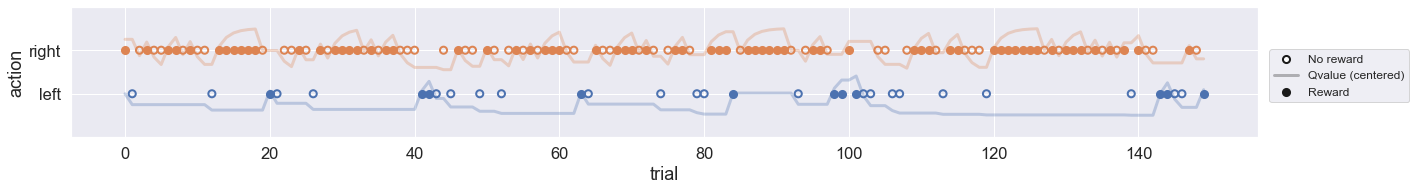

In [9]:
true_alpha = .5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(true_alpha, true_beta, n)

plot_data(actions, rewards, Qs)


## Estimating the learning parameters via Maximum Likelihood


In [18]:
def llik_td(x, *args):
    alpha, beta = x
    actions, rewards = args

    # init values 
    Q = np.array([0.5, 0.5])
    log_prob_actions = np.zeros(len(actions))

    for t, (a,r) in enumerate(zip(actions, rewards)):
        # softmax
        Q_ = Q * beta
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # store the log probability of the observed action 
        log_prob_actions[t] = log_prob_action[a]

        # update Q
        Q[a] = Q[a] + alpha * (r-Q[a])

    return -np.sum(log_prob_actions[1:])

In [19]:
llik_td([true_alpha, true_beta], *(actions, rewards))


62.08084942766952

In [26]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(actions, rewards), method='BFGS')
print(result)
print('')
print(f'MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})')
print(f'MLE: beta = {result.x[1]:.2f} (true value = {true_beta})')



      fun: 61.97619022035591
 hess_inv: array([[ 0.00844417, -0.03200111],
       [-0.03200111,  0.68710612]])
      jac: array([-2.38418579e-06,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([0.48737112, 4.71499809])

MLE: alpha = 0.49 (true value = 0.5)
MLE: beta = 4.71 (true value = 5)


## Vectorized

In [27]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Create a list with the Q values of each trial
    Qs = np.ones((n, 2), dtype=np.float)
    Qs[0] = .5
    for t, (a, r) in enumerate(zip(actions[:-1], rewards[:-1])):  # The last Q values were never used, so there is no need to compute them
        Qs[t+1, a] = Qs[t, a] + alpha * (r - Qs[t, a])
        Qs[t+1, 1-a] = Qs[t, 1-a]

    # Apply the softmax transformation in a vectorized way
    Qs_ = Qs * beta
    log_prob_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the log_prob_actions for the observed actions
    log_prob_actions = log_prob_actions[np.arange(len(actions)), actions]
    return -np.sum(log_prob_actions[1:])




In [29]:
llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))
%timeit llik_td([true_alpha, true_beta], *(actions, rewards))
%timeit llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))


/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_32388/742960438.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Qs = np.ones((n, 2), dtype=np.float)


2.08 ms ± 83.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
273 µs ± 841 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Update Q function

In [30]:
def update_Q(action, reward,
             Qs,
             alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [37]:
# Transform the variables into appropriate Theano objects
rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
actions_ = theano.shared(np.asarray(actions, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * tt.ones(2, dtype='float64')

# Compute the Q values for each trial
Qs, _ = theano.scan(
    fn=update_Q,
    sequences=[actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

# Apply the softmax transformation
Qs_ = Qs * beta
log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# Calculate the negative log likelihod of the observed actions
log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]-1), actions_[1:]]
neg_log_like = -tt.sum(log_prob_actions)

NameError: name 'pm' is not defined

In [40]:
!conda install -c conda-forge python=3.8.8 -y
import pymc3 as pm

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /Users/zachwolpe/miniforge3/envs/dynocog

  added / updated specs:
    - python=3.8.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.16.0               |    he69dfd1_1008         1.3 MB  conda-forge
    cffi-1.14.6                |   py38h0957451_0         220 KB  conda-forge
    curl-7.80.0                |       h8fe1914_1         140 KB  conda-forge
    gettext-0.19.8.1           |    hea66d9f_1005         3.2 MB  conda-forge
    graphviz-2.49.1            |       h2097151_0         3.7 MB  conda-forge
    libgd-2.3.3                |       h39df092_0         249 KB  conda-forge
    libglib-2.68.4             |       h6c200e4_0         2.8 MB  conda-forge
    librsvg-2.52.2             |       h957afdb_0         5.9 MB  

AttributeError: module 'arviz' has no attribute 'geweke'